## Self driving car model

In [ ]:
!git clone https://github.com/tzudir/Self_driving

Cloning into 'Self_driving'...
remote: Enumerating objects: 138284, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 138284 (delta 2), reused 1 (delta 0), pack-reused 138276
Receiving objects: 100% (138284/138284), 1.45 GiB | 13.76 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Updating files: 100% (112595/112595), done.


In [ ]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as keras
import tensorflow as tf
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Lambda, BatchNormalization
from keras.optimizers import Adam
from keras.optimizers import schedules
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath

In [ ]:
datadir = '/content/Self_driving/drive2'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [1]:
num_bins = 25
samples_per_bin = 6000
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5

NameError: name 'np' is not defined

In [ ]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

removed:  4575
remaining:  17253


In [ ]:
hist, bins = np.histogram(data['steering'], (num_bins))

In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [ ]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [ ]:
image_paths

array(['/content/Self_driving/drive2/IMG/center_2019_04_02_18_05_37_993.jpg',
       '/content/Self_driving/drive2/IMG/left_2019_04_02_18_05_37_993.jpg',
       '/content/Self_driving/drive2/IMG/right_2019_04_02_18_05_37_993.jpg',
       ...,
       '/content/Self_driving/drive2/IMG/center_2019_04_02_18_31_04_640.jpg',
       '/content/Self_driving/drive2/IMG/left_2019_04_02_18_31_04_640.jpg',
       '/content/Self_driving/drive2/IMG/right_2019_04_02_18_31_04_640.jpg'],
      dtype='<U67')

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state = 6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 41407
Valid Samples: 10352


In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [ ]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))

  model.add(Dense(50, activation = 'elu'))

  model.add(Dense(10, activation = 'elu'))


  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               115300    
                                                                 
 dense_5 (Dense)             (None, 50)               

In [ ]:
# def get_model():
#     model = Sequential([
#         Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=(66, 200, 3)),
#         BatchNormalization(axis=1),
#         Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'),
#         BatchNormalization(axis=1),
#         Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'),
#         BatchNormalization(axis=1),
#         Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
#         BatchNormalization(axis=1),
#         Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
#         BatchNormalization(axis=1),
#         Flatten(),
#         Dense(100, activation='relu'),
#         BatchNormalization(),
#         Dense(50, activation='relu'),
#         BatchNormalization(),
#         Dense(10, activation='relu'),
#         BatchNormalization(),
#         Dense(1)
#     ])

#     return model

# model = get_model()
# initial_learning_rate = 0.001
# lr_schedule = schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=10000,
#     decay_rate=0.9,
#     staircase=True)

# sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
# model.compile(optimizer=sgd, loss="mse")
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 batch_normalization (Batch  (None, 31, 98, 24)        124       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 47, 36)        56        
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 batch_normalization_2 (Bat  (None, 5, 22, 48)         2

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=20,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

<ipython-input-27-7404206d07fa>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/20
300/300 [==============================] - 122s 398ms/step - loss: 0.2699 - val_loss: 0.1896
Epoch 2/20
300/300 [==============================] - 120s 403ms/step - loss: 0.2015 - val_loss: 0.1706
Epoch 3/20
300/300 [==============================] - 120s 401ms/step - loss: 0.1905 - val_loss: 0.1635
Epoch 4/20
300/300 [==============================] - 117s 392ms/step - loss: 0.1812 - val_loss: 0.1647
Epoch 5/20
300/300 [==============================] - 119s 397ms/step - loss: 0.1727 - val_loss: 0.1597
Epoch 6/20
300/300 [==============================] - 117s 391ms/step - loss: 0.1685 - val_loss: 0.1571
Epoch 7/20
300/300 [==============================] - 117s 393ms/step - loss: 0.1655 - val_loss: 0.1557
Epoch 8/20
300/300 [==============================] - 117s 391ms/step - loss: 0.1598 - val_loss: 0.1447
Epoch 9/20
300/300 [==============================] - 132s 440ms/step - loss: 0.1612 - val_loss: 0.1454
Epoch 10/20
300/300 [==============================] - 132s 440m

Text(0.5, 0, 'Epoch')

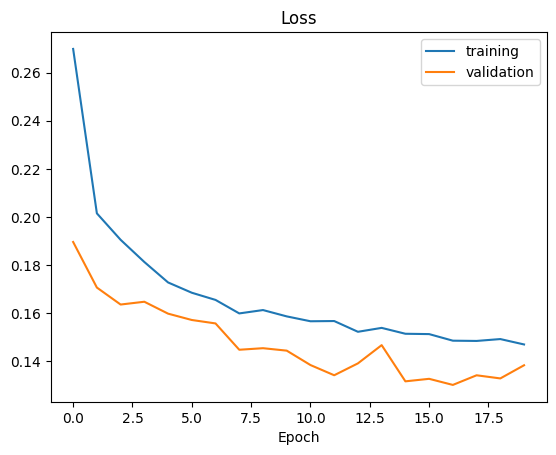

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model11.h5')
from google.colab import files
files.download('model11.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

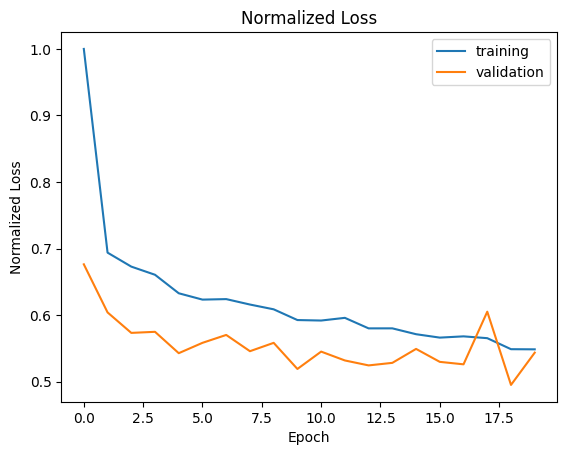

In [ ]:
# Assuming history.history['loss'] and history.history['val_loss'] contain the loss values
# Normalize the loss values
max_loss = max(max(history.history['loss']), max(history.history['val_loss']))
normalized_loss = [loss / max_loss for loss in history.history['loss']]
normalized_val_loss = [val_loss / max_loss for val_loss in history.history['val_loss']]

plt.plot(normalized_loss)
plt.plot(normalized_val_loss)
plt.legend(['training', 'validation'])
plt.title('Normalized Loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.show()
